In [214]:
import pandas as pd
import pandas_datareader as web
import yfinance as yf
import numpy as np
import statsmodels.api as smf
import matplotlib.pyplot as plt

## CAPM - Un solo fattore

Lewinson (2020) Python for Finance Cookbook - cap. 4

### Calcolo del beta vs mercato azionario

In [215]:
risky_asset = 'AMZN' # Amazon
market_benchmark = '^GSPC' # S&P 500
start_date = '2014-05-31'
end_date = '2024-04-30'

In [216]:
df = yf.download([risky_asset, market_benchmark],
                       start = start_date, end = end_date)

[*********************100%%**********************]  2 of 2 completed


In [217]:
df.head()

Price       Adj Close                   Close                    High  \
Ticker           AMZN        ^GSPC       AMZN        ^GSPC       AMZN   
Date                                                                    
2014-06-02  15.442000  1924.969971  15.442000  1924.969971  15.630000   
2014-06-03  15.359500  1924.239990  15.359500  1924.239990  15.396000   
2014-06-04  15.339000  1927.880005  15.339000  1927.880005  15.475000   
2014-06-05  16.178499  1940.459961  16.178499  1940.459961  16.396999   
2014-06-06  16.483500  1949.439941  16.483500  1949.439941  16.544001   

Price                        Low                  Open               \
Ticker            ^GSPC     AMZN        ^GSPC     AMZN        ^GSPC   
Date                                                                  
2014-06-02  1925.880005  15.3500  1915.979980  15.6295  1923.869995   
2014-06-03  1925.069946  15.2535  1918.790039  15.2875  1923.069946   
2014-06-04  1928.630005  15.1920  1918.599976  15.3425  1923.060059   
2014-06-05  1941.739990  15.3450  1922.930054  15.4050  1928.520020   
2014-06-06  1949.439941  16.2465  1942.410034  16.2500  1942.410034   

Price          Volume              
Ticker           AMZN       ^GSPC  
Date                               
2014-06-02   44068000  2509020000  
2014-06-03   47584000  2867180000  
2014-06-04   42142000  2793920000  
2014-06-05  155934000  3113270000  
2014-06-06  104880000  2864300000

In [218]:
X = df['Adj Close'].rename(columns={risky_asset:'asset', market_benchmark:'market'})\
.resample('ME').last().pct_change().dropna()


In [219]:
X.head()

Ticker,asset,market
Date,,
2014-07-31,-0.036302,-0.015080
2014-08-31,0.083229,0.037655
2014-09-30,-0.048962,-0.015514
2014-10-31,-0.052661,0.023201
2014-11-30,0.108623,0.024534


In [220]:
X.cov()

Ticker,asset,market
Ticker,,
asset,0.008127,0.002491
market,0.002491,0.001952


In [221]:
covariance = X.cov().iloc[0,1]
covariance

0.0024913541872845202

In [222]:
X.corr()

Ticker,asset,market
Ticker,,
asset,1.000000,0.625489
market,0.625489,1.000000


In [223]:
benchmark_variance = X.market.var()

In [224]:
X.market.var()

0.0019521024529134015

In [225]:
beta = covariance / benchmark_variance
beta

1.2762415126144206

### CAPM - 1 solo fattore

In [226]:
y = X.pop('asset')
y

Date
2014-07-31   -0.036302
2014-08-31    0.083229
2014-09-30   -0.048962
2014-10-31   -0.052661
2014-11-30    0.108623
                ...   
2023-12-31    0.040044
2024-01-31    0.021456
2024-02-29    0.138918
2024-03-31    0.020480
2024-04-30    0.003215
Freq: ME, Name: asset, Length: 118, dtype: float64

In [227]:

X = smf.add_constant(X)
X

,const,market
Date,,
2014-07-31,1.0,-0.015080
2014-08-31,1.0,0.037655
2014-09-30,1.0,-0.015514
2014-10-31,1.0,0.023201
2014-11-30,1.0,0.024534
...,...,...
2023-12-31,1.0,0.044229
2024-01-31,1.0,0.015896
2024-02-29,1.0,0.051721


In [228]:
capm_model = smf.OLS(y, X).fit()
capm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  asset   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     74.55
Date:                Sun, 19 May 2024   Prob (F-statistic):           3.67e-14
Time:                        17:00:40   Log-Likelihood:                 146.29
No. Observations:                 118   AIC:                            -288.6
Df Residuals:                     116   BIC:                            -283.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0129      0.007      1.943      0.054      -0.000       0.026
market         1.2762      0.148      8.634      0.000       0.983       1.569
==============================================================================
Omnibus:                        3.383   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.184   Jarque-Bera (JB):                2.832
Skew:                           0.286   Prob(JB):                        0.243
Kurtosis:                       3.498   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Inseriamo il risk free

In [229]:
risk_free = '^IRX'

In [230]:
df = yf.download([risky_asset, market_benchmark, risk_free],
                       start = start_date, end = end_date)

[*********************100%%**********************]  3 of 3 completed


In [231]:
df.head()

Price       Adj Close                          Close                      \
Ticker           AMZN        ^GSPC   ^IRX       AMZN        ^GSPC   ^IRX   
Date                                                                       
2014-06-02  15.442000  1924.969971  0.025  15.442000  1924.969971  0.025   
2014-06-03  15.359500  1924.239990  0.030  15.359500  1924.239990  0.030   
2014-06-04  15.339000  1927.880005  0.030  15.339000  1927.880005  0.030   
2014-06-05  16.178499  1940.459961  0.030  16.178499  1940.459961  0.030   
2014-06-06  16.483500  1949.439941  0.028  16.483500  1949.439941  0.028   

Price            High                         Low                      \
Ticker           AMZN        ^GSPC  ^IRX     AMZN        ^GSPC   ^IRX   
Date                                                                    
2014-06-02  15.630000  1925.880005  0.03  15.3500  1915.979980  0.025   
2014-06-03  15.396000  1925.069946  0.03  15.2535  1918.790039  0.030   
2014-06-04  15.475000  1928.630005  0.03  15.1920  1918.599976  0.028   
2014-06-05  16.396999  1941.739990  0.03  15.3450  1922.930054  0.028   
2014-06-06  16.544001  1949.439941  0.03  16.2465  1942.410034  0.028   

Price          Open                        Volume                   
Ticker         AMZN        ^GSPC  ^IRX       AMZN       ^GSPC ^IRX  
Date                                                                
2014-06-02  15.6295  1923.869995  0.03   44068000  2509020000  0.0  
2014-06-03  15.2875  1923.069946  0.03   47584000  2867180000  0.0  
2014-06-04  15.3425  1923.060059  0.03   42142000  2793920000  0.0  
2014-06-05  15.4050  1928.520020  0.03  155934000  3113270000  0.0  
2014-06-06  16.2500  1942.410034  0.03  104880000  2864300000  0.0

In [232]:
X1 = df['Adj Close'].rename(columns={risky_asset:'asset', market_benchmark:'market', risk_free: 'risk_free'})


In [233]:
X1.head()

Ticker,asset,market,risk_free
Date,,,
2014-06-02,15.442000,1924.969971,0.025
2014-06-03,15.359500,1924.239990,0.030
2014-06-04,15.339000,1927.880005,0.030
2014-06-05,16.178499,1940.459961,0.030
2014-06-06,16.483500,1949.439941,0.028


In [234]:
X1 = X1.resample('M').last()
X1

C:\Users\utente\AppData\Local\Temp\ipykernel_8104\349035461.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  X1 = X1.resample('M').last()


Ticker,asset,market,risk_free
Date,,,
2014-06-30,16.239000,1960.229980,0.020
2014-07-31,15.649500,1930.670044,0.018
2014-08-31,16.952000,2003.369995,0.018
2014-09-30,16.122000,1972.290039,0.013
2014-10-31,15.273000,2018.050049,0.003
...,...,...,...
2023-12-31,151.940002,4769.830078,5.180
2024-01-31,155.199997,4845.649902,5.188
2024-02-29,176.759995,5096.270020,5.223


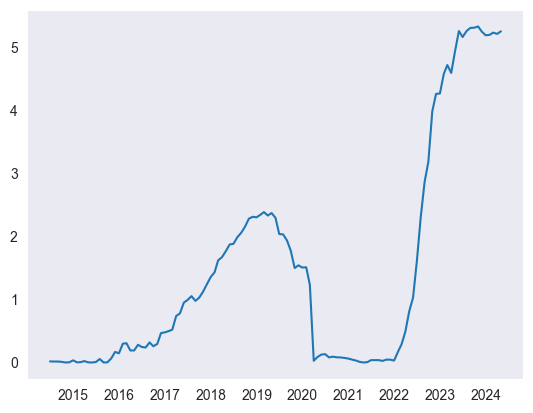

In [235]:
plt.plot(X1['risk_free'])
plt.grid()

In [236]:
X1['mrf'] = (1 + X1['risk_free']/100)**(30/360) - 1

In [237]:
X1[50:70]

Ticker,asset,market,risk_free,mrf
Date,,,,
2018-08-31,100.635498,2901.520020,2.055,0.001697
2018-09-30,100.150002,2913.979980,2.150,0.001774
2018-10-31,79.900497,2711.739990,2.278,0.001879
2018-11-30,84.508499,2760.169922,2.308,0.001903
2018-12-31,75.098503,2506.850098,2.300,0.001897
2019-01-31,85.936501,2704.100098,2.340,0.001929
2019-02-28,81.991501,2784.489990,2.383,0.001964
2019-03-31,89.037498,2834.399902,2.328,0.001920
2019-04-30,96.325996,2945.830078,2.368,0.001952


In [238]:
X1.tail()

Ticker,asset,market,risk_free,mrf
Date,,,,
2023-12-31,151.940002,4769.830078,5.180,0.004217
2024-01-31,155.199997,4845.649902,5.188,0.004224
2024-02-29,176.759995,5096.270020,5.223,0.004252
2024-03-31,180.380005,5254.350098,5.203,0.004236
2024-04-30,180.960007,5116.169922,5.243,0.004268


In [239]:
X1['asset_nmr'] = X1['asset'].pct_change() - X1['mrf']

In [240]:
X1['market_nmr'] = X1['market'].pct_change() - X1['mrf']

In [241]:
X1.head()

Ticker,asset,market,risk_free,mrf,asset_nmr,market_nmr
Date,,,,,,
2014-06-30,16.2390,1960.229980,0.020,0.000017,NaN,NaN
2014-07-31,15.6495,1930.670044,0.018,0.000015,-0.036317,-0.015095
2014-08-31,16.9520,2003.369995,0.018,0.000015,0.083214,0.037640
2014-09-30,16.1220,1972.290039,0.013,0.000011,-0.048973,-0.015525
2014-10-31,15.2730,2018.050049,0.003,0.000002,-0.052663,0.023199


In [242]:
X1.tail()

Ticker,asset,market,risk_free,mrf,asset_nmr,market_nmr
Date,,,,,,
2023-12-31,151.940002,4769.830078,5.180,0.004217,0.035826,0.040012
2024-01-31,155.199997,4845.649902,5.188,0.004224,0.017232,0.011672
2024-02-29,176.759995,5096.270020,5.223,0.004252,0.134666,0.047469
2024-03-31,180.380005,5254.350098,5.203,0.004236,0.016244,0.026783
2024-04-30,180.960007,5116.169922,5.243,0.004268,-0.001052,-0.030566


In [243]:
X1.dropna(inplace=True)

In [244]:
X1.head()

Ticker,asset,market,risk_free,mrf,asset_nmr,market_nmr
Date,,,,,,
2014-07-31,15.649500,1930.670044,0.018,0.000015,-0.036317,-0.015095
2014-08-31,16.952000,2003.369995,0.018,0.000015,0.083214,0.037640
2014-09-30,16.122000,1972.290039,0.013,0.000011,-0.048973,-0.015525
2014-10-31,15.273000,2018.050049,0.003,0.000002,-0.052663,0.023199
2014-11-30,16.931999,2067.560059,0.005,0.000004,0.108619,0.024529


In [245]:
X2 = X1[['asset_nmr', 'market_nmr']]

In [246]:
X2.head()

Ticker,asset_nmr,market_nmr
Date,,
2014-07-31,-0.036317,-0.015095
2014-08-31,0.083214,0.037640
2014-09-30,-0.048973,-0.015525
2014-10-31,-0.052663,0.023199
2014-11-30,0.108619,0.024529


In [247]:
y = X2.pop('asset_nmr')

In [248]:
X = smf.add_constant(X2)
X

,const,market_nmr
Date,,
2014-07-31,1.0,-0.015095
2014-08-31,1.0,0.037640
2014-09-30,1.0,-0.015525
2014-10-31,1.0,0.023199
2014-11-30,1.0,0.024529
...,...,...
2023-12-31,1.0,0.040012
2024-01-31,1.0,0.011672
2024-02-29,1.0,0.047469


In [249]:
capm_model = smf.OLS(y, X).fit()
capm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              asset_nmr   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     74.68
Date:                Sun, 19 May 2024   Prob (F-statistic):           3.52e-14
Time:                        17:00:44   Log-Likelihood:                 146.31
No. Observations:                 118   AIC:                            -288.6
Df Residuals:                     116   BIC:                            -283.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.007      2.002      0.048       0.000       0.026
market_nmr     1.2779      0.148      8.642      0.000       0.985       1.571
==============================================================================
Omnibus:                        3.347   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                2.791
Skew:                           0.286   Prob(JB):                        0.248
Kurtosis:                       3.491   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [250]:
#Il tasso risk free si può anche scaricare dal database della Banca della Riserva Federale di Saint Louis (FRED)

rf = web.DataReader("TB3MS", "fred", start = start_date, end = end_date)

In [251]:
rf = (1 + (rf/100))**(1/12)-1

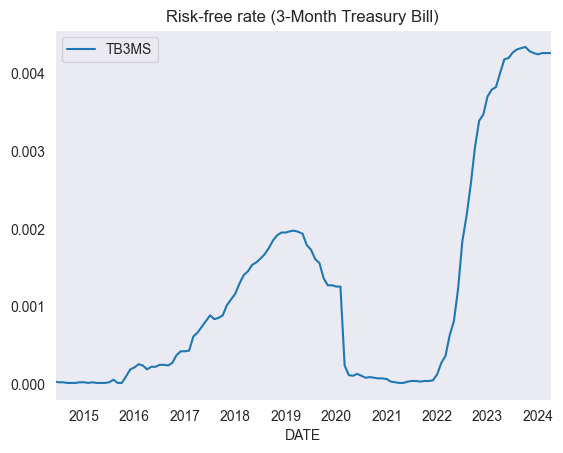

In [252]:
rf.plot(title = "Risk-free rate (3-Month Treasury Bill)")
plt.grid()

### Il modello di Fama - French a tre fattori

I tre fattori del modello di Fama e French (*) sono:
- il fattore mercato, cioè la dipendenza dall'andamento del mercato azionario  (MKT)
- il fattore dimensione (SMB) costruito come rendimento in eccesso delle azioni a piccola capitalizzazione rispetto alle grandi
- il fattore valore (HML) costruito come rendimento in eccesso delle azioni con un rapporto fra patrimonio e prezzo alto (Value stocks) e quelle con un rapporto fra patrimonio e prezzo basso (Growth stocks)

I dati vanno scaricati da questo sito:
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

Come abbiamo detto in precedenza, ci sono più fattori di rischio che spiegano l'andamento delle azioni: il modello di Fama e French ne prende in considerazione tre. <br>
A parte il fattore di mercato, preso in considerazione anche dal CAPM, ci sono due ulteriori fattori di rischio:
- fattore dimensione (SMB), cioè se la società è grande o piccola
- fattore valore (HML), cioè se l'azione di una società è cara o no

Se si osservano gli andamenti di società ad alta capitalizzazione e bassa capitalizzazione, ci si può rendere conto che esse si comportano in maniera diversa: questo accade per diversi motivi, tra cui il fatto che le società ad alta capitalizzazione sono più liquide (cioè molto più comprate, perché quando si costruisce un portafoglio si parte dai titoli più grossi), sono più seguite dagli analisti finanziari (quindi su di esse sono disponibili molte informazioni) ed inoltre godono spesso di un minor rischio intrinseco (ovvero riescono a superare più facilmente periodi di crisi).

__NOTA BENE__: una piccola società è molto più soggetta al rischio specifico: se schioppa il fondatore di una piccola società allora son cazzi; se invece schioppa il CEO di Stellantis sti cazzi, sotto ha una struttura enorme che consente alla società di andare avanti comunque.

L'altro fattore invece è quello legato al valore: si può constatare che esistono titoli che il mercato paga di più (in rapporto all'utile per azione realizzato) e titoli che il mercato invece paga di meno; questo fatto è legato alle prospettive di crescita di ciascuna azienda.
Per quanto riguarda il potenziale di crescita è anche importante considerare le differenze nei diversi mercati di business a cui le aziende si affacciano: i titoli più costosi sono titoli che hanno avuto (e continueranno ad avere) una crescita importante dovuta anche alla tipologia di mercato (di business) di cui si occupano.

__ESEMPIO__: le prospettive di crescita di una società come ad esempio A2A sono legate prettamente al fatto che essa può acquisire altre società dello stesso settore, non al fatto che di punto in bianco i consumatori inizieranno ad usare 3 impianti di riscaldamento invece che 1; al contrario, società come quelle tecnologiche stanno attualmente cavalcando un mercato di business in fortissima espansione.

Ricapitolando, il mercato (gli investitori) disprezza le aziende piccole e per questo motivo le aziende piccole rendono di più (costano meno, quindi sono in grado di generare rendimenti maggiori) ed inoltre disprezza le aziende Value (cioè quelle con un alto rapporto tra patrimonio e prezzo).

__PER CAPIRE__: il mercato è disposto a pagare i titoli che "vanno di moda" più di quanto effettivamente essi valgano.

//CONTINUA MINUTO 8:30

In [253]:
factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)

In [254]:
factor_df.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


Definiamo i parametri

In [255]:
risky_asset = 'X' #azione da analizzare con i fattori di rischio
start_date = '2014-05-31'
end_date = '2024-03-31'

Eliminiamo i dati annuali in fondo al file

In [256]:
stringa = ' Annual Factors: January-December '
indices = factor_df.iloc[:,0] == stringa
start_of_annual = factor_df[indices].index[0]
factor_df = factor_df[factor_df.index < start_of_annual]

Rinominiamo le colonne, definiamo come indice la data, filtriamo l'intervallo che ci interessa, dividiamo tutto per 100

In [257]:
factor_df.columns = ['data', 'mkt', 'smb', 'hml', 'rf']

In [258]:
factor_df['data'] = pd.to_datetime(factor_df['data'], format='%Y%m').dt.strftime("%Y-%m")

In [259]:
factor_df.head()

,data,mkt,smb,hml,rf
0,1926-07,2.96,-2.56,-2.43,0.22
1,1926-08,2.64,-1.17,3.82,0.25
2,1926-09,0.36,-1.40,0.13,0.23
3,1926-10,-3.24,-0.09,0.70,0.32
4,1926-11,2.53,-0.10,-0.51,0.31


In [260]:
factor_df = factor_df.set_index('data')
factor_df = factor_df[start_date:end_date]

In [261]:
factor_df.head()

,mkt,smb,hml,rf
data,,,,
2014-06,2.61,3.09,-0.70,0.00
2014-07,-2.04,-4.29,0.03,0.00
2014-08,4.24,0.40,-0.45,0.00
2014-09,-1.97,-3.71,-1.34,0.00
2014-10,2.52,4.21,-1.81,0.00


In [262]:
factor_df.tail()

,mkt,smb,hml,rf
data,,,,
2023-11,8.84,-0.02,1.64,0.44
2023-12,4.87,6.34,4.93,0.43
2024-01,0.71,-5.09,-2.38,0.47
2024-02,5.06,-0.24,-3.49,0.42
2024-03,2.83,-2.49,4.19,0.43


In [263]:
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)

In [264]:
factor_df.head()

,mkt,smb,hml,rf
data,,,,
2014-06,0.0261,0.0309,-0.0070,0.0
2014-07,-0.0204,-0.0429,0.0003,0.0
2014-08,0.0424,0.0040,-0.0045,0.0
2014-09,-0.0197,-0.0371,-0.0134,0.0
2014-10,0.0252,0.0421,-0.0181,0.0


Scarichiamo i prezzi dell'azione e calcoliamo i rendimenti mensili

In [265]:
risky_asset = 'TSLA'
asset_df = yf.download(risky_asset, start_date, end_date) 

[*********************100%%**********************]  1 of 1 completed


In [266]:
y = asset_df['Adj Close'].resample('M').last().pct_change().dropna()

C:\Users\utente\AppData\Local\Temp\ipykernel_8104\2402912227.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = asset_df['Adj Close'].resample('M').last().pct_change().dropna()


In [267]:
y.index = y.index.strftime('%Y-%m')

In [268]:
y.name = 'rtn'

In [269]:
y.head()

Date
2014-07   -0.069816
2014-08    0.207792
2014-09   -0.100185
2014-10   -0.004038
2014-11    0.011667
Name: rtn, dtype: float64

Uniamo i due df e calcoliamo i rendimenti in eccesso rispetto al rf dell'azione

In [270]:
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

In [271]:
ff_data.head()

,mkt,smb,hml,rf,rtn,excess_rtn
data,,,,,,
2014-06,0.0261,0.0309,-0.0070,0.0,NaN,NaN
2014-07,-0.0204,-0.0429,0.0003,0.0,-0.069816,-0.069816
2014-08,0.0424,0.0040,-0.0045,0.0,0.207792,0.207792
2014-09,-0.0197,-0.0371,-0.0134,0.0,-0.100185,-0.100185
2014-10,0.0252,0.0421,-0.0181,0.0,-0.004038,-0.004038


Stimiamo il modello a tre fattori

In [272]:
import statsmodels.formula.api as smf
ff_model = smf.ols(formula = 'excess_rtn ~ mkt + smb + hml', data = ff_data).fit()
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     16.19
Date:                Sun, 19 May 2024   Prob (F-statistic):           8.06e-09
Time:                        17:00:48   Log-Likelihood:                 56.588
No. Observations:                 117   AIC:                            -105.2
Df Residuals:                     113   BIC:                            -94.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0157      0.014      1.083      0.2

#### Modello Fama French a tre fattori rolling su un portafoglio

Parametri

In [273]:
assets = ['JPM','X','JNJ','CSCO']
weights = [0.25, 0.25, 0.25, 0.25]
start_date = '2014-05-31'
end_date = '2024-03-31'

Carichiamo i dati di Fama French in un altro modo

In [274]:
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)[0]

C:\Users\utente\AppData\Local\Temp\ipykernel_8104\1440863999.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)[0]
C:\Users\utente\AppData\Local\Temp\ipykernel_8104\1440863999.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)[0]


In [275]:
df_three_factor.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-05,2.06,-1.88,-0.13,0.0
2014-06,2.61,3.09,-0.70,0.0
2014-07,-2.04,-4.29,0.03,0.0
2014-08,4.24,0.40,-0.45,0.0
2014-09,-1.97,-3.71,-1.34,0.0


In [276]:
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

C:\Users\utente\AppData\Local\Temp\ipykernel_8104\1033079253.py:2: FutureWarning: PeriodIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_three_factor.index = df_three_factor.index.format()


In [277]:
df_three_factor.head()

,Mkt-RF,SMB,HML,RF
2014-05,0.0206,-0.0188,-0.0013,0.0
2014-06,0.0261,0.0309,-0.0070,0.0
2014-07,-0.0204,-0.0429,0.0003,0.0
2014-08,0.0424,0.0040,-0.0045,0.0
2014-09,-0.0197,-0.0371,-0.0134,0.0


Carichiamo i prezzi delle quattro azioni 

In [278]:
asset_df = yf.download(assets, start_date, end_date) 

[*********************100%%**********************]  4 of 4 completed


In [279]:
asset_df = asset_df['Adj Close'].resample('M').last().pct_change().dropna()

C:\Users\utente\AppData\Local\Temp\ipykernel_8104\3727152988.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  asset_df = asset_df['Adj Close'].resample('M').last().pct_change().dropna()


In [280]:
asset_df.index = asset_df.index.strftime('%Y-%m')
asset_df.head()

Ticker,CSCO,JNJ,JPM,X
Date,,,,
2014-07,0.023042,-0.043299,0.007864,0.286098
2014-08,-0.009512,0.043377,0.030865,0.155708
2014-09,0.014879,0.027571,0.013289,0.013454
2014-10,-0.027811,0.011164,0.010748,0.022211
2014-11,0.129547,0.010902,-0.005291,-0.165928


Calcoliamo i rendimenti del portafoglio

In [281]:
asset_df['portfolio_returns'] = np.matmul(asset_df[assets].values, weights)

In [282]:
asset_df.head()

Ticker,CSCO,JNJ,JPM,X,portfolio_returns
Date,,,,,
2014-07,0.023042,-0.043299,0.007864,0.286098,0.068426
2014-08,-0.009512,0.043377,0.030865,0.155708,0.055110
2014-09,0.014879,0.027571,0.013289,0.013454,0.017298
2014-10,-0.027811,0.011164,0.010748,0.022211,0.004078
2014-11,0.129547,0.010902,-0.005291,-0.165928,-0.007692


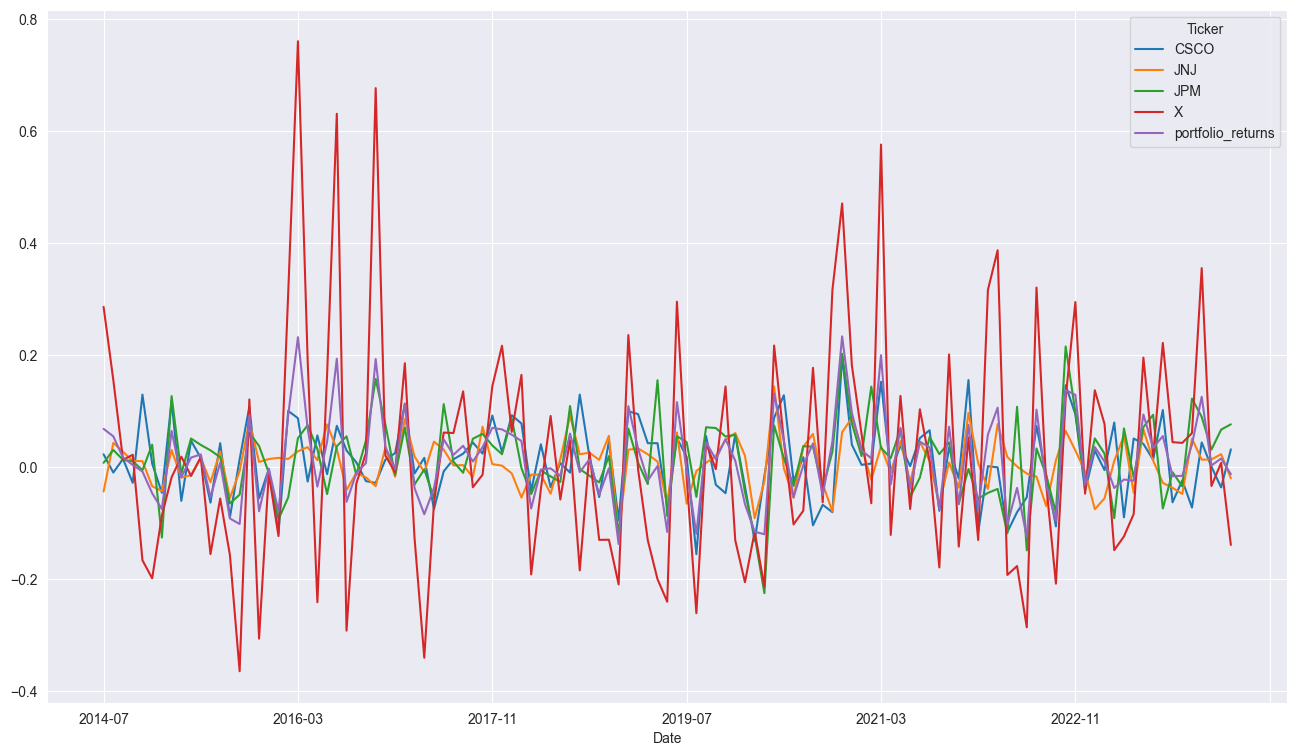

In [283]:
asset_df.plot(figsize=(16,9), grid = True);

Uniamo i due df

In [284]:
ff_data = asset_df.join(df_three_factor).drop(assets, axis = 1)

In [285]:
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

In [286]:
ff_data.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
Date,,,,,,
2014-07,0.068426,-0.0204,-0.0429,0.0003,0.0,0.068426
2014-08,0.055110,0.0424,0.0040,-0.0045,0.0,0.055110
2014-09,0.017298,-0.0197,-0.0371,-0.0134,0.0,0.017298
2014-10,0.004078,0.0252,0.0421,-0.0181,0.0,0.004078
2014-11,-0.007692,0.0255,-0.0206,-0.0309,0.0,-0.007692


Creiamo una funzione per calcolare la regressione ricorrente

In [287]:
def rolling_factor_model(input_data, formula, window_size):
    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):        
        end_index = start_index + window_size

        # define and fit the regression model 
        ff_model = smf.ols(formula=formula,data=input_data[start_index:end_index]).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:])

    return coeffs_df

In [288]:
model_formula = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, model_formula, window_size = 36)

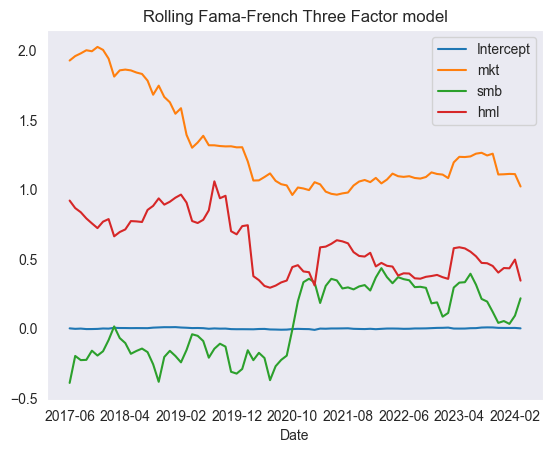

In [289]:
results_df.plot(title = 'Rolling Fama-French Three Factor model')
plt.grid();

### Modelo di Carhart a quattro fattori e Fama e French a cinque fattori

In [290]:
risky_asset = 'AMZN'
start_date = '2014-05-31'
end_date = '2024-03-31'

In [291]:
# tre fattori
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start = start_date)[0]
df_three_factor.index = df_three_factor.index.format()

C:\Users\utente\AppData\Local\Temp\ipykernel_8104\2002033036.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start = start_date)[0]
C:\Users\utente\AppData\Local\Temp\ipykernel_8104\2002033036.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start = start_date)[0]
C:\Users\utente\AppData\Local\Temp\ipykernel_8104\2002033036.py:3: FutureWarning: PeriodIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_three_factor.index = df_three_factor.ind

In [292]:
# quattro fattori con fattore "momentum" di Carhart
df_mom = web.DataReader('F-F_Momentum_factor', 'famafrench', start = start_date)[0]
df_mom.index = df_mom.index.format()

C:\Users\utente\AppData\Local\Temp\ipykernel_8104\548808727.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_mom = web.DataReader('F-F_Momentum_factor', 'famafrench', start = start_date)[0]
C:\Users\utente\AppData\Local\Temp\ipykernel_8104\548808727.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_mom = web.DataReader('F-F_Momentum_factor', 'famafrench', start = start_date)[0]
C:\Users\utente\AppData\Local\Temp\ipykernel_8104\548808727.py:3: FutureWarning: PeriodIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_mom.index = df_mom.index.format()


In [293]:
# cinque fattori con fattori Robust Minus Weak (RMW) e Conservative Minus Aggressive (CMA)
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = start_date)[0]
df_five_factor.index = df_five_factor.index.format()

C:\Users\utente\AppData\Local\Temp\ipykernel_8104\3415908415.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = start_date)[0]
C:\Users\utente\AppData\Local\Temp\ipykernel_8104\3415908415.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = start_date)[0]
C:\Users\utente\AppData\Local\Temp\ipykernel_8104\3415908415.py:3: FutureWarning: PeriodIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_five_factor.index = df_five_fa

In [294]:
asset_df = yf.download(risky_asset,
                       start = start_date, end = end_date)

[*********************100%%**********************]  1 of 1 completed


In [295]:
y = asset_df['Adj Close'].resample('M').last().pct_change().dropna()
y.index = y.index.strftime('%Y-%m')
y.name = 'return'

C:\Users\utente\AppData\Local\Temp\ipykernel_8104\1812768267.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = asset_df['Adj Close'].resample('M').last().pct_change().dropna()


In [296]:
y

Date
2014-07   -0.036302
2014-08    0.083229
2014-09   -0.048962
2014-10   -0.052661
2014-11    0.108623
             ...   
2023-11    0.097678
2023-12    0.040044
2024-01    0.021456
2024-02    0.138918
2024-03    0.020480
Name: return, Length: 117, dtype: float64

In [297]:
four_factor_data = df_three_factor.join(df_mom).join(y)

In [298]:
four_factor_data.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']

In [299]:
four_factor_data.loc[:,four_factor_data.columns != 'rtn'] /= 100

In [300]:
#four_factor_data.index = pd.to_datetime(four_factor_data.index, format = '%Y-%m')
four_factor_data.dropna(inplace = True)

In [301]:
four_factor_data = four_factor_data.loc[start_date:end_date]

In [302]:
four_factor_data['excess_rtn'] = four_factor_data['rtn'] - four_factor_data['rf']

In [303]:
four_factor_data.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2014-07,-0.0204,-0.0429,0.0003,0.0,-0.0012,-0.036302,-0.036302
2014-08,0.0424,0.0040,-0.0045,0.0,0.0082,0.083229,0.083229
2014-09,-0.0197,-0.0371,-0.0134,0.0,0.0050,-0.048962,-0.048962
2014-10,0.0252,0.0421,-0.0181,0.0,-0.0006,-0.052661,-0.052661
2014-11,0.0255,-0.0206,-0.0309,0.0,0.0069,0.108623,0.108623


In [304]:
four_factor_model = smf.ols(formula ='excess_rtn ~ mkt + smb + hml + mom', data = four_factor_data).fit()

In [305]:
print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     37.45
Date:                Sun, 19 May 2024   Prob (F-statistic):           7.41e-20
Time:                        17:00:53   Log-Likelihood:                 165.23
No. Observations:                 117   AIC:                            -320.5
Df Residuals:                     112   BIC:                            -306.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0090      0.006      1.559      0.1

In [306]:
five_factor_data = df_five_factor.join(y)

In [307]:
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']

In [308]:
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

In [309]:
#five_factor_data.index = pd.to_datetime(five_factor_data.index, format = '%Y-%m')

In [310]:
five_factor_data.dropna(inplace = True)

In [311]:
five_factor_data = five_factor_data.loc[start_date:end_date]

In [312]:
five_factor_data['excess_rtn'] = five_factor_data['rtn'] - five_factor_data['rf']

In [313]:
five_factor_data.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2014-07,-0.0204,-0.0429,0.0003,0.0089,0.0052,0.0,-0.036302,-0.036302
2014-08,0.0424,0.0031,-0.0045,-0.0064,-0.0070,0.0,0.083229,0.083229
2014-09,-0.0197,-0.0372,-0.0134,0.0130,-0.0051,0.0,-0.048962,-0.048962
2014-10,0.0252,0.0373,-0.0181,-0.0057,-0.0011,0.0,-0.052661,-0.052661
2014-11,0.0255,-0.0228,-0.0309,0.0150,0.0027,0.0,0.108623,0.108623


In [314]:
five_factor_model = smf.ols(formula ='excess_rtn ~ mkt + smb + hml + rmw + cma', data = five_factor_data).fit()

In [315]:
print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     38.30
Date:                Sun, 19 May 2024   Prob (F-statistic):           1.13e-22
Time:                        17:00:54   Log-Likelihood:                 174.21
No. Observations:                 117   AIC:                            -336.4
Df Residuals:                     111   BIC:                            -319.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0118      0.005      2.178      0.0

#### Andamento nel tempo degli indici MSCI

In [316]:
data = pd.read_excel('MSCI_Value_Growth.xlsx', index_col = 0, parse_dates = True)

In [317]:
returns = (data/data.shift(1)) - 1
returns.dropna(inplace=True)

In [318]:
returns.head()

,NDUEACWF,M1WD000V,M1WD000G
Data,,,
2001-02-28,-0.084330,-0.049030,-0.126423
2001-03-31,-0.067679,-0.053215,-0.082523
2001-04-30,0.072410,0.068015,0.075015
2001-05-31,-0.011752,-0.006962,-0.014897
2001-06-30,-0.030922,-0.027529,-0.034565


In [319]:
plt.plot(cum)
plt.grid();

NameError: name 'cum' is not defined